<a href="https://colab.research.google.com/github/splopsky/ML-practice/blob/main/Linear_Model_Selection_and_Regularization_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###6.5.1 Best Subset Selection

In [2]:
#imports and setup
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from itertools import chain, combinations
import statsmodels.api as sm

pd.set_option('precision', 2) # number precision for pandas
pd.set_option('display.max_rows', 12)
pd.set_option('display.max_columns', 12)
pd.set_option('display.float_format', '{:20,.2f}'.format) #get rid of scientific notation

plt.style.use('seaborn') # pretty matplotlib plots

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
hitters = pd.read_csv('/content/drive/MyDrive/datasets/Hitters.csv', index_col=0).dropna()
hitters.index.name = 'Player'

hitters = hitters.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,18]] # push salary at the end
hitters['League'] = pd.get_dummies(hitters['League']).iloc[:,0]
hitters['Division'] = pd.get_dummies(hitters['Division']).iloc[:,0]
hitters['NewLeague'] = pd.get_dummies(hitters['NewLeague']).iloc[:,0]

X = hitters.iloc[:, 0:19]
y = hitters.iloc[:, 19]

In [ ]:
# takes a long time

k_features = 1

sub = []
reg = []
kft = []

n_features = X.shape[1]

for k_features in range(1,20):
  subsets = chain(combinations(range(n_features), k_features))

  best_score = np.inf
  
  for subset in subsets:
    lin_reg = sm.OLS(y, sm.add_constant(X.iloc[:, list(subset)])).fit()
    score = lin_reg.ssr
    if score < best_score:
      best_score, best_subset = score, list(subset)
      best_reg = lin_reg

  sub.append(best_subset)
  reg.append(best_reg)
  kft.append(k_features)

results = pd.DataFrame({'kft': kft, 'sub': sub, 'reg': reg},
                       columns = ['sub', 'reg', 'kft']).set_index('kft')

KeyboardInterrupt: ignored

In [5]:
results = pd.read_pickle('/content/drive/MyDrive/datasets/results_651')

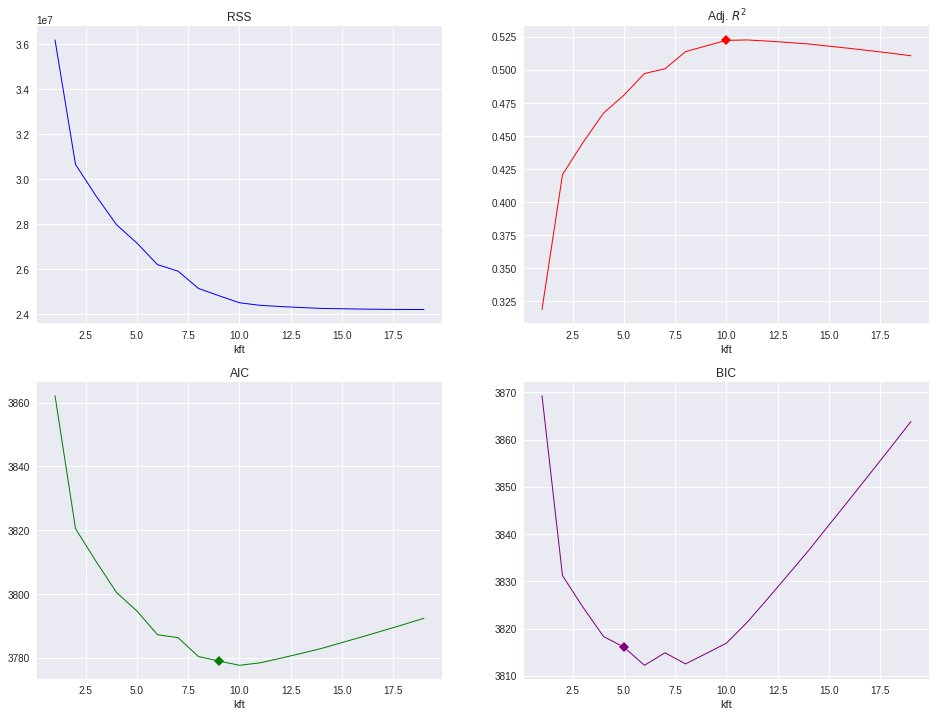

In [6]:
plt.figure(figsize=(16,12))

plt.subplot(2, 2, 1)
results.rss.plot(title='RSS', lw=1, color='blue')

plt.subplot(2, 2, 2)
max_r2a = results.r2a.argmax()-1
results.r2a.plot(title='Adj. $R^2$', markevery=[max_r2a], marker='D', lw=1, color='red')

plt.subplot(2, 2, 3)
min_aic = results.aic.argmin()-1
results.aic.plot(title='AIC', markevery=[min_aic], marker='D', lw=1, color='green')

plt.subplot(2, 2, 4)
min_bic = results.bic.argmin()-1
results.bic.plot(title='BIC', markevery=[min_bic], marker='D', lw=1, color='purple')


###6.5.2. Foward and Backward Stepwise Selection

In [7]:
def processSubset(feature_set):
  #Fit model on feature_set and calculate RSS
  model = sm.OLS(y, X[list(feature_set)])
  regr = model.fit()
  RSS = regr.ssr
  return {'model': regr, 'RSS': RSS}

In [8]:
def foward(predictors):

  #Pull out predictors we still need to process
  remaining_predictors = [p for p in X.columns if p not in predictors]

  results = []

  for p in remaining_predictors:
    results.append(processSubset(predictors+[p]))

  #Wrap everything up in a nic dataframe
  models = pd.DataFrame(results)

  #Choose the model with the lowest RSS
  best_model = models.loc[models['RSS'].argmin()]

  #Return the best model, along with some other useful information about the model
  return best_model

def backward(predictors):

  results = []

  for combo in combinations(predictors, len(predictors)-1):
    results.append(processSubset(combo))

  #Wrap everything up in a nice dataframe
  models = pd.DataFrame(results)

  #Choose the model with the lowest RSS
  best_model = models.loc[models['RSS'].argmin()]

  return best_model

Foward Selection:

In [9]:
models2 = pd.DataFrame(columns=['RSS', 'model'])

predictors = []

for i in range(1,len(X.columns)+1):
  models2.loc[i] = foward(predictors)
  predictors = models2.loc[i]['model'].model.exog_names

bic_f = []

for m in models2.model:
  bic_f.append(m.bic)

np.array(bic_f).argmin()

5

In [10]:
predictors, bic_f

(['Hits',
  'CRBI',
  'PutOuts',
  'AtBat',
  'Division',
  'Walks',
  'CWalks',
  'CRuns',
  'CAtBat',
  'Assists',
  'Runs',
  'League',
  'HmRun',
  'Errors',
  'NewLeague',
  'RBI',
  'CHits',
  'Years',
  'CHmRun'],
 [3910.437405792022,
  3826.372838539718,
  3820.626997734044,
  3815.4605878697303,
  3810.7331322124824,
  3806.8883425646886,
  3809.8597898274984,
  3807.1870192596657,
  3809.3387521975437,
  3811.923580691154,
  3816.5713995697747,
  3821.5191822804245,
  3826.8028102714034,
  3832.1077814957293,
  3837.456294954363,
  3842.8214798303275,
  3848.225835229507,
  3853.720486189592,
  3859.2816820271046])

Run backward stepwise selection

In [11]:
models3 = pd.DataFrame(columns=['RSS','model'], index = range(1, len(X.columns)))

predictors = X.columns

while(len(predictors) > 1):
  models3.loc[len(predictors)-1] = backward(predictors)
  predictors = models3.loc[len(predictors)-1]['model'].model.exog_names

bic_b = []

for m in models3.model:
  bic_b.append(m.bic)

np.array(bic_b).argmin()

7

###6.5.3 Choosing Among Models Using the Validation Set Approach and Cross-Validation

Foward stepwise selection using validation set approach

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=3)

In [13]:
def processSubset(feature_set, X_train, y_train, X_test, y_test):
  #Fit model on feature_set and calculate RSS
  model = sm.OLS(y_train,X_train[list(feature_set)])
  regr = model.fit()
  RSS = ((regr.predict(X_test[list(feature_set)]) - y_test) ** 2).sum()
  return {'model':regr, 'RSS':RSS}


In [14]:
def foward(predictors, X_train, y_train, X_test, y_test):

  #Pull out predictors we still need to process
  remaining_predictors = [p for p in X_train.columns if p not in predictors]

  results =[]

  for p in remaining_predictors:
    results.append(processSubset(predictors+[p], X_train, y_train, X_test, y_test))

  #Wrap everything up in a nice dataframe
  models = pd.DataFrame(results)

  #Choose the model with the highest RSS
  best_model = models.loc[models['RSS'].argmin()]

  #Return the best model, along with some other useful information about the model
  return best_model

In [15]:
models_train = pd.DataFrame(columns=['RSS', 'model'])

predictors = []

for i in range(1,len(X.columns)+1):
  models_train.loc[i] = foward(predictors, X_train, y_train, X_test, y_test)
  predictors = models_train.loc[i]['model'].model.exog_names

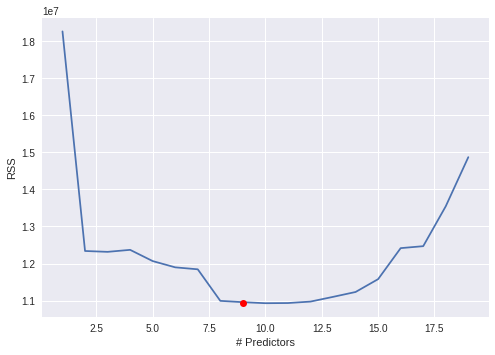

In [16]:
plt.plot(models_train['RSS'])
plt.xlabel('# Predictors')
plt.ylabel('RSS')
plt.plot(models_train['RSS'].argmin(), models_train['RSS'].min(), 'or');

###6.6.1 Ridge Regression

Apply ridge regression

In [17]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import scale

grid = 10 ** np.linspace(3,-2,100)

ridge_model = Ridge(normalize=True)
coefs = []

for a in grid:
  ridge_model.set_params(alpha=a)
  ridge_model.fit(X,y)
  coefs.append(ridge_model.coef_)

Results of ridge regression

In [44]:
grid[49]

3.351602650938841

In [45]:
pd.Series(coefs[49], index=X.columns)

AtBat                       0.11
Hits                        0.49
HmRun                       1.32
Runs                        0.76
RBI                         0.73
                    ...         
Division                   33.63
PutOuts                     0.08
Assists                     0.01
Errors                     -0.30
NewLeague                  -5.36
Length: 19, dtype: float64

Text(0, 0.5, 'weights')

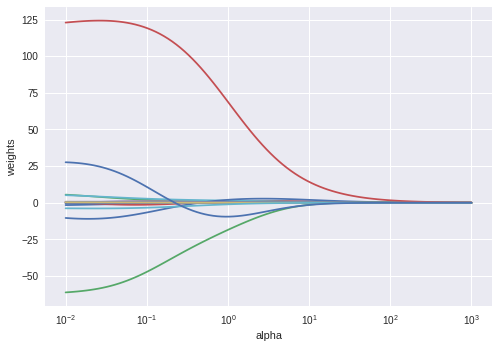

In [46]:
ax = plt.gca()
ax.plot(grid, coefs)
ax.set_xscale('log')

plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

Good ridge model using validation set approach

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [52]:
# "good" ridge model
ridge2 = Ridge(alpha=4, normalize=True)
ridge2_fit = ridge2.fit(X_train, y_train)
y_pred2 = ridge2.predict(X_test)

print(pd.Series(ridge2_fit.coef_, index=X.columns))
print('MSE:', mean_squared_error(y_test, y_pred2))

AtBat                       0.10
Hits                        0.45
HmRun                       1.41
Runs                        0.66
RBI                         0.84
                    ...         
Division                   30.77
PutOuts                     0.10
Assists                    -0.00
Errors                      0.27
NewLeague                  -4.12
Length: 19, dtype: float64
MSE: 106216.52238005563


Very high lambda

In [54]:
#very high lambda
ridge3 = Ridge(alpha=1e10, normalize=True)
ridge3_fit = ridge3.fit(X_train, y_train)
y_pred3 = ridge3.predict(X_test)

print(pd.Series(ridge3_fit.coef_, index=X.columns))
print('MSE:', mean_squared_error(y_test, y_pred3))

AtBat                       0.00
Hits                        0.00
HmRun                       0.00
Runs                        0.00
RBI                         0.00
                    ...         
Division                    0.00
PutOuts                     0.00
Assists                    -0.00
Errors                      0.00
NewLeague                   0.00
Length: 19, dtype: float64
MSE: 172862.23580379886


Lambda = 0 -> least square regression

In [56]:
# lambda=0 -> OLS
ridge4 = Ridge(alpha=0, normalize=True)
ridge4_fit = ridge4.fit(X_train, y_train)
y_pred4 = ridge4.predict(X_test)

print(pd.Series(ridge4_fit.coef_, index=X.columns))
print('MSE:', mean_squared_error(y_test, y_pred4))

AtBat                      -1.82
Hits                        4.26
HmRun                      -4.77
Runs                       -0.04
RBI                         3.98
                    ...         
Division                  113.74
PutOuts                     0.42
Assists                     0.46
Errors                     -6.02
NewLeague                  81.93
Length: 19, dtype: float64
MSE: 116690.46856660125


Cross-validated ridge

In [57]:
#cross validated ridge
ridge_cv = RidgeCV(alphas=grid, normalize=True, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train, y_train)
ridge_cv.alpha_

0.5857020818056667

In [58]:
#cv_lambda
ridge5 = Ridge(alpha=ridge_cv.alpha_, normalize=True)
ridge5_fit = ridge5.fit(X_train, y_train)
y_pred5 = ridge5.predict(X_test)

print(pd.Series(ridge5_fit.coef_, index=X.columns))
print('MSE:', mean_squared_error(y_test, y_pred5))

AtBat                      -0.01
Hits                        0.86
HmRun                      -0.26
Runs                        0.72
RBI                         1.31
                    ...         
Division                   91.61
PutOuts                     0.28
Assists                    -0.02
Errors                     -0.30
NewLeague                  -9.99
Length: 19, dtype: float64
MSE: 99805.36301929559


###6.6.2 The Lasso

Results of Lasso

In [24]:
from sklearn.preprocessing import scale

grid = 10 ** np.linspace(3,-2,100)

lasso_model = Lasso(normalize=True, max_iter=10000) #max_iter=1000 for removing ConvergenceWarning
coefs = []

for a in grid:
  lasso_model.set_params(alpha=a)
  lasso_model.fit(scale(X_train), y_train)
  coefs.append(lasso_model.coef_)


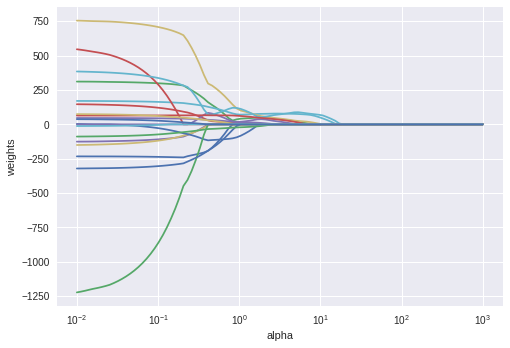

In [26]:
ax = plt.gca()
ax.plot(grid, coefs)
ax.set_xscale('log')

plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights');

Cross-validated Lasso (10-fold)

In [27]:
lasso_cv = LassoCV(alphas=grid, max_iter=100000, normalize=True, cv=10)
lasso_cv.fit(X_train, y_train)
lasso_cv.alpha_

0.03199267137797385

In [28]:
lasso2 = Lasso(alpha=lasso_cv.alpha_, normalize=True, max_iter=10000)
lasso2_fit = lasso2.fit(X_train, y_train)
y_pred2 = lasso2_fit.predict(X_test)

print(pd.Series(lasso2_fit.coef_, index=X.columns))
print('MSE:', mean_squared_error(y_test, y_pred2))

AtBat                      -1.58
Hits                        6.72
HmRun                      16.69
Runs                       -4.73
RBI                        -5.75
                    ...         
Division                  128.59
PutOuts                     0.17
Assists                     0.50
Errors                     -1.64
NewLeague                  69.61
Length: 19, dtype: float64
MSE: 120545.37850368311


###6.7.1 Principal Components Regression

Scikitlearn for principle component regression

In [30]:
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSSVD, PLSRegression
from sklearn.metrics import mean_squared_error

In [31]:
pca =  PCA()
X_pca = pca.fit_transform(scale(X))
pd.DataFrame(X_pca)

,0,1,2,3,4,5,...,13,14,15,16,17,18
0,-0.01,1.87,1.27,-0.94,1.11,1.21,...,0.39,0.06,0.14,0.08,0.04,-0.02
1,0.41,-2.43,-0.91,-0.26,1.23,1.83,...,-0.02,0.07,0.16,0.04,0.01,-0.00
2,3.47,0.83,0.56,-1.62,-0.86,-1.03,...,-0.38,0.23,0.01,-0.22,0.04,-0.07
3,-2.56,-0.23,0.52,-2.18,-0.82,1.49,...,0.03,0.04,0.05,-0.04,0.01,-0.01
4,1.03,-1.57,1.33,3.49,0.98,0.51,...,-0.09,0.04,0.01,-0.05,0.13,-0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,-0.33,-0.17,0.78,-1.54,-1.04,-0.31,...,-0.16,0.23,-0.22,0.13,-0.06,-0.01
259,3.25,-0.54,1.21,2.75,-1.20,0.83,...,0.32,-0.14,0.01,-0.15,-0.05,-0.06
260,-1.09,-0.75,-0.94,1.07,0.71,-0.64,...,0.09,0.06,-0.10,-0.08,0.07,0.01
261,1.98,-2.18,-0.28,-0.22,-0.69,3.51,...,-0.23,0.02,-0.26,-0.01,0.02,-0.01


Selection of number of principle components based on 10-fold CV

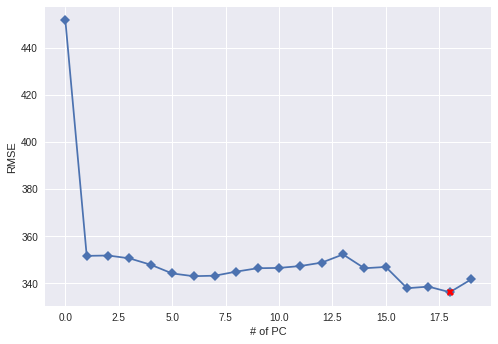

In [33]:
# 10-fold CV, with shuffle
n = len(X_pca)
k10 = KFold(n_splits=10, shuffle=True, random_state=42)

lin_reg = LinearRegression()
rmse = []

#MSE with only the intercept
score = -1 * cross_val_score(lin_reg, np.ones((n,1)), y, cv=k10, scoring='neg_mean_squared_error').mean()
rmse.append(np.sqrt(score))

#MSE for the 19 principle components
for i in np.arange(1,20):
  score = -1 * cross_val_score(lin_reg, X_pca[:,:i], y, cv=k10, scoring='neg_mean_squared_error').mean()
  rmse.append(np.sqrt(score))

min_rmse = np.array(rmse).argmin()

plt.plot(rmse, '-D')
plt.plot(rmse, markevery=[min_rmse], marker='X', lw=0, color='red')
plt.xlabel('# of PC')
plt.ylabel('RMSE');

###6.7.2 Partial Least Squares

Partial least squares with 10-fold CV

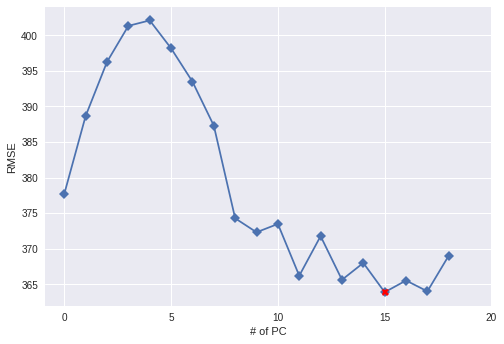

In [34]:
# 10-fold CV, with shuffle
n = len(X_train)
k10 = KFold(n_splits=10, shuffle=True, random_state=1)

rmse = []

for i in np.arange(1, 20):
  pls = PLSRegression(n_components=i)
  score = -1 * cross_val_score(pls, scale(X_train), y_train, cv=k10, scoring='neg_mean_squared_error').mean()
  rmse.append(np.sqrt(score))

min_rmse = np.array(rmse).argmin()

plt.plot(rmse, '-D')
plt.plot(rmse, markevery=[min_rmse], marker='X', lw=0, color='red')
plt.xlabel('# of PC')
plt.ylabel('RMSE')
plt.xticks([0, 5, 10, 15, 20]);